In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
from IPython.display import display
import threading
import cv2
import numpy as np
from enum import Enum
from collections import deque
import imutils
import time
import json

from balltracker_app import *
from videoplayer import *

In [3]:
test = BallTracker(source='../../../videos/vincent_court.mp4',
                   data_path='vincent_court.json')
test.start(threaded=True)

started


In [12]:
test.load_balls(path='vincent_court.json')

In [4]:
test.save_balls(path='vincent_court.json')

In [10]:
test.start_data()

In [11]:
test.stop_data()

In [12]:
test.save_balls(path='vincent_court.json')

In [9]:
list(test.balls['Vert'].data.items())

[(0.0, (660, 641)),
 (16.666666666666668, (657, 607)),
 (33.333333333333336, (654, 575)),
 (50.0, (651, 545)),
 (66.66666666666667, (647, 517)),
 (83.33333333333334, (643, 490)),
 (100.0, (639, 466)),
 (116.66666666666667, (636, 444)),
 (133.33333333333334, (632, 424)),
 (150.0, (628, 406)),
 (166.66666666666669, (623, 390)),
 (183.33333333333334, (619, 378)),
 (200.0, (615, 368)),
 (216.66666666666669, (611, 360)),
 (233.33333333333334, (607, 354)),
 (250.0, (603, 350)),
 (266.6666666666667, (600, 347)),
 (283.3333333333333, (596, 346))]

In [14]:
def detect_duplicate_frames(path): #fonctionne pas :(
    vp = VideoPlayer(path)
    if vp.video_type == VideoType.WEBCAM:
        print("Impossible avec webcam.")
        return
    vp.loop = False
    duplicated_frames = []
    ret, last_frame = vp.read()
    i = 0
    while True:
        i += 1
        ret, frame = vp.read()
        #print(ret, end=' ')
        if not ret:
            break
        #print(np.sum(frame - last_frame), end=' ')
        """if np.array_equal(frame, last_frame):
            duplicated_frames.append(i)"""
        last_frame = frame
        cv2.imshow('duplicate_frames', frame)
        cv2.waitKey(0)
    vp.release()
    cv2.destroyAllWindows()
    return duplicated_frames

In [4]:
import matplotlib.pyplot as plt
from balltracker_app import *
%matplotlib inline

def untuplize(l):
    #l est une liste de tuples de même longueur.
    if len(l) == 0:
        return ()
    return tuple(np.array([elem[i] for elem in l]) for i in range(len(l[0])))

"""def tuplize(*args):
    #args est fait de listes toute de même longueur
    if len(args) == 0:
        return []
    return [tuple(arg[i] for arg in args) for i in range(len(args[0]))]"""

def plot_data(path, ignore_nan = False):
    with open(path, 'r') as f:
        data = json.load(f)
    balls = [Ball.from_dict(ball_data) for ball_data in data]
    
    #temps en ms
    to_plot = [{"x" : "t",   "y" : "x",  "xlabel" : "temps", "ylabel" : "x"},
               {"x" : "t",   "y" : "y",  "xlabel" : "temps", "ylabel" : "y"},
               {"x" : "tv",  "y" : "vx", "xlabel" : "temps", "ylabel" : "vx"},
               {"x" : "tv",  "y" : "vy", "xlabel" : "temps", "ylabel" : "vy"},
               {"x" : "ta", "y" : "ax", "xlabel" : "temps", "ylabel" : "ax"},
               {"x" : "ta", "y" : "ay", "xlabel" : "temps", "ylabel" : "ay"}]
    
    fig, axes = plt.subplots(len(to_plot), 1, figsize=(12, 5*len(to_plot)))
    
    for ball in balls:
        ball_data_list = [(key, *elem) for key, elem in ball.data.items()]
        ball_data_list.sort(key = lambda x : x[0])
        t, x, y = untuplize(ball_data_list)
        if ignore_nan:
            #On suppose x nan ssi y nan
            #Ceci est un moyen étrange mais fonctionnel de retirer les nan.
            mask = (x <= float('infinity'))
            t, x, y = t[mask], x[mask], y[mask]
                    
        dt = t[1:] - t[:-1]
        dt2 = dt[:-1]
        tv = t[:-1]
        ta = t[:-2]
        vx = (x[1:] - x[:-1]) / dt
        vy = (y[1:] - y[:-1]) / dt
        ax = (vx[1:] - vx[:-1]) / dt2
        ay = (vy[1:] - vy[:-1]) / dt2
        var = {"t" : t, "tv" : tv, "ta" : ta, "x" : x, "y" : y, "vx" : vx, "vy" : vy,
               "ax" : ax, "ay" : ay}
        
        for i, data in enumerate(to_plot):
            axes[i].plot(var[data['x']], var[data['y']], color=ball.plt_color)
        #ax[0].plot(t, x, color=ball.plt_color, label=ball.name)
        #plt.figlegend()
        
    for i, data in enumerate(to_plot):
        if 'xlabel' in data:
            axes[i].set_xlabel(data['xlabel'])
        if 'ylabel' in data:
            axes[i].set_xlabel(data['ylabel'])
        axes[i].set_xticks(data.get('xticks', np.linspace(t[0], t[-1], 5))) #a corriger
    #A CONFIGURER ABSOLUMENT sinon la figure met des années à s'afficher
    #ax[0].set_xticks(np.linspace(int(t[0]), t[-1], 5))


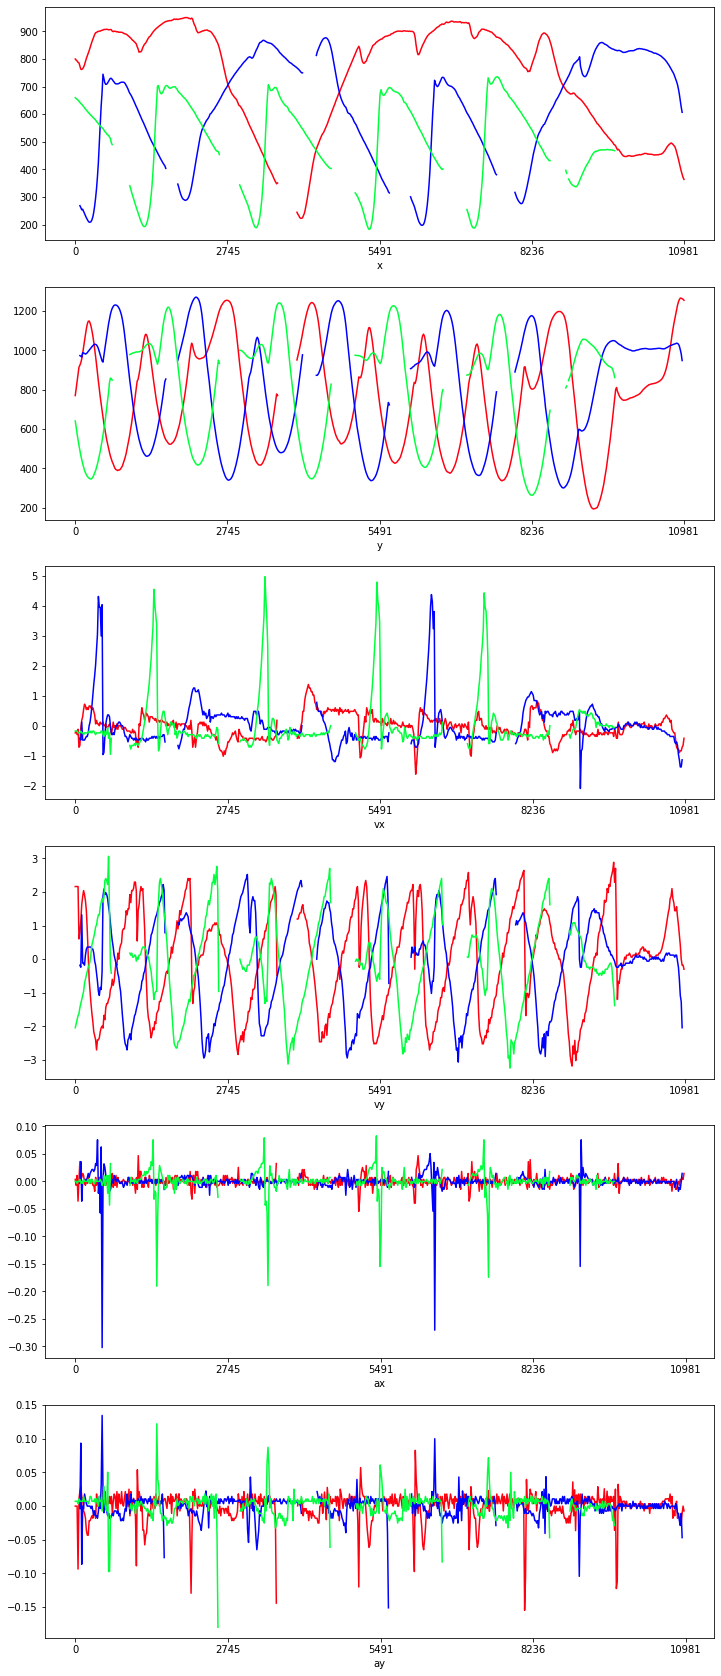

In [5]:
plot_data('vincent_court.json', ignore_nan=False)

In [68]:
path = 'test_train.json'
with open(path, 'r') as f:
    data = json.load(f)
balls = [Ball.from_dict(ball_data) for ball_data in data]
#fig, ax = plt.subplots(2, 1)

In [69]:
ball = balls[0]
for key, elem in ball.data.items():
    if not isinstance(elem, list):
        print(key)

9800.0


In [72]:
ball.data

{'66.66669999994338': [306, 329],
 '100.0': [307, 327],
 '133.33330000005662': [306, 329],
 '166.66669999994338': [304, 331],
 '200.0': [300, 330],
 '233.33330000005662': [299, 331],
 '266.6666999999434': [296, 341],
 '300.0': [295, 328],
 '333.3333000000566': [296, 320],
 '366.6666999999434': [297, 326],
 '400.0': [300, 327],
 '433.3333000000566': [302, 329],
 '466.6666999999434': [303, 326],
 '500.0': [305, 318],
 '533.3333000000566': [308, 326],
 '566.6666999999434': [313, 324],
 '600.0': [318, 318],
 '633.3333000000566': [325, 317],
 '666.6666999999434': [331, 327],
 '700.0': [338, 330],
 '733.3333000000566': [333, 329],
 '766.6666999999434': [343, 326],
 '800.0': [346, 320],
 '833.3333000000566': [335, 326],
 '866.6666999999434': [316, 350],
 '900.0': [312, 349],
 '933.3333000000566': [311, 347],
 '966.6666999999434': [311, 347],
 '1000.0': [304, 355],
 '1033.3333000000566': [308, 324],
 '1066.6666999999434': [304, 330],
 '1100.0': [297, 330],
 '1133.3333000000566': [292, 326],
 '

In [ ]:
b = widgets.Dropdown(options=[1, 2, 3])
b.observe(lambda change : print(change), names="value")
display(b)

In [130]:
b.options = [1, 2, 3, 4]

In [131]:
 b.value = 2

{'name': 'value', 'old': 1, 'new': 2, 'owner': Dropdown(index=1, options=(1, 2, 3, 4), value=2), 'type': 'change'}


In [ ]:
a = Test()
b = Test()
print({"a":a, "b":b})

In [ ]:
isinstance(Mode.QUIT, Mode)

In [88]:
debug_view

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'text': "{'JV': {'lower_hsv…

In [17]:
class Test:
    def __init__(self):
        self.button = widgets.Button(layout={'width': '300px'})
        self.button.on_click(lambda b: self.oups())
        self.i = 0
    
    @debug_view.capture(clear_output=True)
    def oups(self):
        print('This is about to explode')
        tmp = 1.0 / 0.0
    
    def print_sleep(self):
        time.sleep(5.0)
        print('thread ', self.i)
    
    def start_thread(self):
        thread = threading.Thread(target = self.print_sleep)
        thread.start()
        print('started ', self.i)
    
    def display(self):
        display(self.button)
    
    def __repr__(self):
        return str(self.i)

a = Test()
a.start_thread()

started  0


In [18]:
a.i = 10

thread  10


In [82]:
debug_view

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'text': 'This is about to e…

In [ ]:
#A rendre fonctionnel un jour avec des vidéos (en plus de webcam)
debug_view = widgets.Output(layout={'border': '1px solid black'})

@debug_view.capture(clear_output=True)
def bad_callback(event):
    print('This is about to explode')
    return 1.0 / 0.0

button = widgets.Button(
    description='click me to raise an exception',
    layout={'width': '300px'}
)
button.on_click(bad_callback())
button

In [ ]:
debug_view